In [45]:
import json
import csv

import numpy as np
import pandas as pd

#import seaborn as sns
#print(sns.__version__)
import matplotlib.pyplot as plt

from utils import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
tweet_folder = '/home/n25tran/HBDC/tweetsv0.2/RawTweets/'
outpath = 'data/tweets_nov30_2017.csv'

tweet_folder_json_to_csv(tweet_folder, outpath)

 92%|█████████▏| 1643147/1777619 [03:38<00:17, 7526.95it/s]

Bad json: {"created_at":"Thu Nov 30 17:04:58 +0000 2017","id":936279900788473856,"id_str":"936279900788473856","text":"Confession- I\u2019m terrified \ud83d\ude2c Jumping out of an airplane, being locked \ud83d\udd12 in a room with drug\u2026 https:\/\/t.co\/j2xRY0yHka","source":"\u003ca href=\"http:\/\/instagram.com\" rel=\"nofollow\"\u003eInstagram\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":161072892,"id_str":"161072892","name":"Pamela Barnum","screen_name":"PamelaBarnum","location":"Canada","url":"http:\/\/www.worklesslivemore.ca","description":"Former undercover drug cop and prosecuting attorney serving a sentence as a workaholic. Paroled to inspire others as an author, speaker and confidence expert.","translator_type":"none","protected":false,"verified":false,"followers_count":550,"friends_count":71,"listed_count":14,"favourites

100%|██████████| 728327/728327 [00:20<00:00, 35946.86it/s]


num_tweets            728327.0
physical_activity      64274.0
sedentary_behavior     36350.0
sleeping               15692.0
dtype: float64


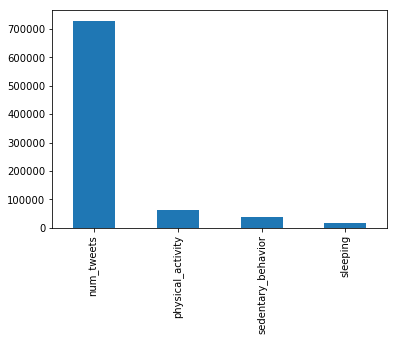

In [13]:
print(regions_df.loc[:, 'num_tweets':].sum())
regions_df.loc[:, 'num_tweets':].sum().plot(kind='bar')

In [18]:
tweets_df = pd.read_csv('./data/tweets_nov30_2017.csv')
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df.index = tweets_df['created_at']
regions_df = tweets_df.groupby(['placename', pd.TimeGrouper('W')]).apply(filter_tweets)
regions_df.sort_values('num_tweets', ascending=False).head()

latitude  longitude  num_tweets  \
placename        created_at                                     
Toronto, Ontario 2017-11-26  43.684176 -79.384742     77533.0   
                 2017-11-19  43.686057 -79.383570     36863.0   
                 2017-12-03  43.683841 -79.384993     34860.0   
Ottawa, Ontario  2017-11-26  45.335271 -74.406904     20672.0   
Montréal, Québec 2017-11-26  45.508706 -73.584917     19483.0   

                             physical_activity  sedentary_behavior  sleeping  
placename        created_at                                                   
Toronto, Ontario 2017-11-26            11123.0              3755.0    1610.0  
                 2017-11-19             2564.0              1587.0     754.0  
                 2017-12-03             5113.0              1675.0     786.0  
Ottawa, Ontario  2017-11-26             1549.0              1278.0     440.0  
Montréal, Québec 2017-11-26             1667.0               863.0     428.0

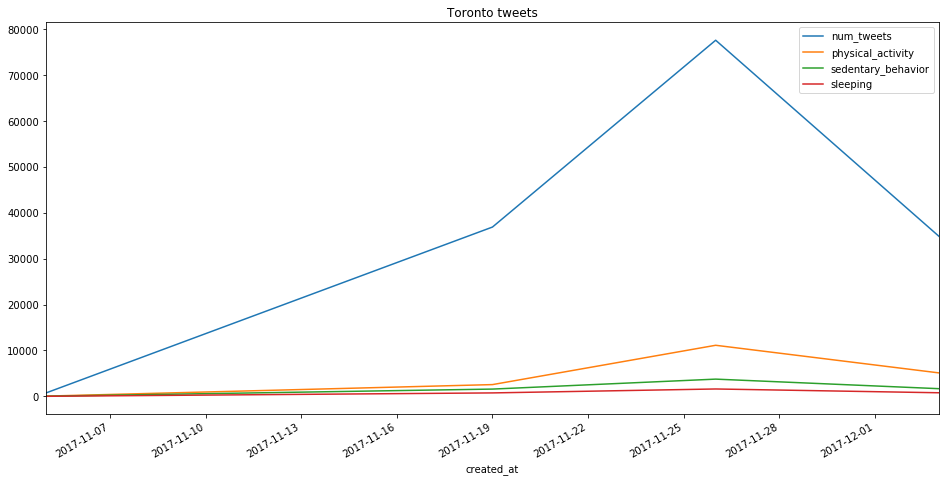

In [66]:
toronto_tweets = regions_df.loc['Toronto, Ontario']

toronto_tweets.plot(y=['num_tweets', 'physical_activity', 'sedentary_behavior', 'sleeping'], figsize=(16, 8), title='Toronto tweets')

In [68]:
sedentary_pattern = r'\s(working|work|watch|chill|games|movies|nba|ufc|nhl|nfl|cfl)'
sleeping_pattern = r'\s(sleep|slept|insomnia|dormir|dodo|rest|nap|zzz|siesta)'

physical_incl = '\s(run|hiking|hike|courir|gym|train|workout|work out|basketball \
                    |ball|hockey|biking|bike|bb|bball|baseball|climb|dance|dancin|ran| \
                    skate|skating|squat|lift|gains|volleyball|yoga)'

physical_excl = 'watch|attend'

physical_activity = r'^(?=.*(?:%s))(?!.*(?:%s)).*$' % (physical_incl, physical_excl)

#toronto_tweets = tweets_df.loc[tweets_df.country == 'Canada']
toronto_tweets = tweets_df.loc[tweets_df.city == 'Toronto']

#toronto_tweets = tweets_df

sedentary = toronto_tweets.text.str.contains(sedentary_pattern) | toronto_tweets.hashtags.str.contains(sedentary_pattern)
sleeping = toronto_tweets.text.str.contains(sleeping_pattern) | toronto_tweets.hashtags.str.contains(sleeping_pattern)
physical = toronto_tweets.text.str.contains(physical_activity) | toronto_tweets.hashtags.str.contains(physical_activity)

cond = sedentary | sleeping | physical

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [56]:
toronto_tweets.loc[cond == False].to_csv('data/tweets_unclassified.csv', index=False)

In [53]:
toronto_tweets.loc[sedentary == True, ['text', 'hashtags', 'placename']].to_csv('data/tweets_sedentary.csv', index=False)

In [54]:
toronto_tweets.loc[sleeping == True, ['text', 'hashtags', 'placename']].to_csv('data/tweets_sleeping.csv', index=False)

In [55]:
toronto_tweets.loc[physical == True, ['text', 'hashtags', 'placename']].to_csv('data/tweets_physical.csv', index=False)

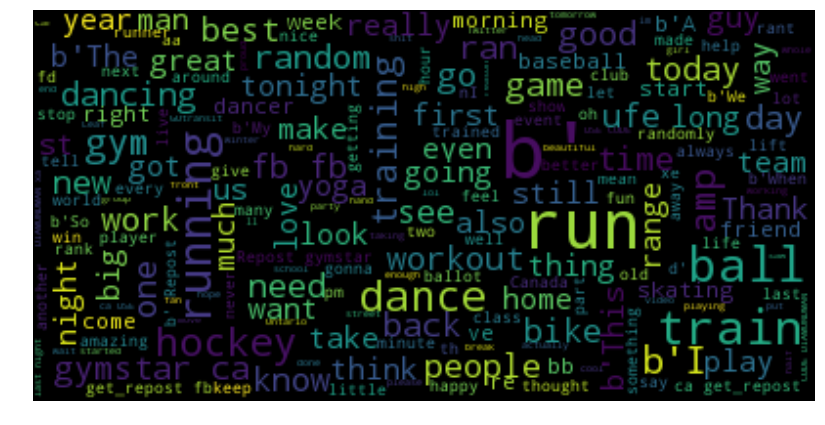

In [192]:
from os import path
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

text = toronto_tweets.loc[physical == True, ['text']].text.as_matrix().tolist()
clean_text = []
for line in text:
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    line = pattern.sub('', line)
    # remove urls
    line = re.sub(r'\http\S+', '', line, flags=re.MULTILINE)
    # remove numbers
    line = re.sub("\d+", " ", line)

    clean_text.append(line)
    
sw = set(STOPWORDS)
sw.add("int")
sw.add("ext")
sw.add("cf")
sw.add("cb")
sw.add("Toronto")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, stopwords=sw).generate(' '.join(clean_text))
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

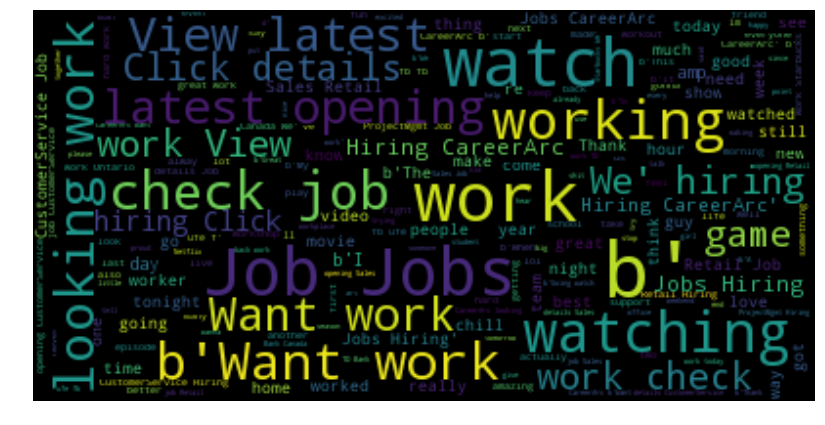

In [189]:
text = toronto_tweets.loc[sedentary == True, ['text']].text.as_matrix().tolist()
clean_text = []
for line in text:
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    line = pattern.sub('', line)
    # remove urls
    line = re.sub(r'\http\S+', '', line, flags=re.MULTILINE)
    # remove numbers
    line = re.sub("\d+", " ", line)

    clean_text.append(line)
    
sw = set(STOPWORDS)
sw.add("int")
sw.add("ext")
sw.add("cf")
sw.add("cb")
sw.add("Toronto")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, stopwords=sw).generate(' '.join(clean_text))
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

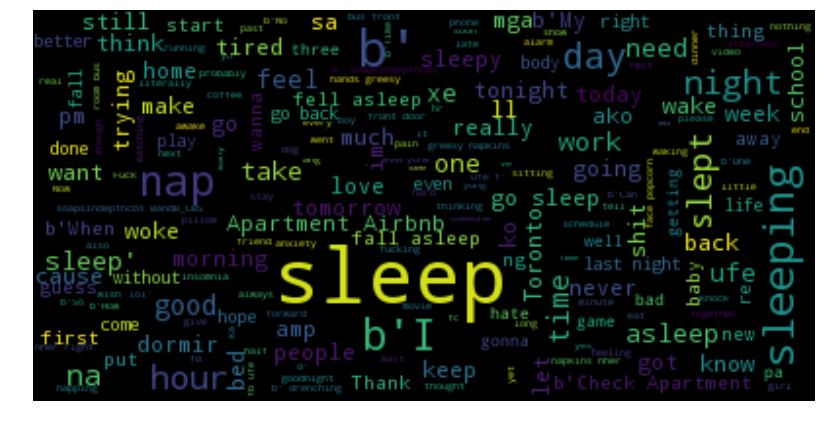

In [193]:
text = toronto_tweets.loc[sleeping == True, ['text']].text.as_matrix().tolist()
clean_text = []
for line in text:
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    line = pattern.sub('', line)
    # remove urls
    line = re.sub(r'\http\S+', '', line, flags=re.MULTILINE)
    # remove numbers
    line = re.sub("\d+", " ", line)

    clean_text.append(line)
    
sw = set(STOPWORDS)
sw.add("int")
sw.add("ext")
sw.add("cf")
sw.add("cb")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, stopwords=sw).generate(' '.join(clean_text))
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
